In [1]:
!pip install rudalle==0.0.1rc1 > /dev/null

In [2]:
from rudalle.pipelines import generate_images, show, super_resolution, cherry_pick_by_clip
from rudalle import get_rudalle_model, get_tokenizer, get_vae, get_realesrgan, get_ruclip
from rudalle.utils import seed_everything

2021-11-02 11:21:12.531833: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
device = 'cuda'
dalle = get_rudalle_model('Malevich', pretrained=True, fp16=True, device=device)

Downloading:   0%|          | 0.00/2.63G [00:00<?, ?B/s]

◼️ Malevich is 1.3 billion params model from the family GPT3-like, that uses Russian language and text+image multi-modality.


In [4]:
realesrgan = get_realesrgan('x4', device=device)
tokenizer = get_tokenizer()
vae = get_vae().to(device)
ruclip, ruclip_processor = get_ruclip('ruclip-vit-base-patch32-v5')
ruclip = ruclip.to(device)

Downloading:   0%|          | 0.00/67.0M [00:00<?, ?B/s]

x4 --> ready


Downloading:   0%|          | 0.00/224k [00:00<?, ?B/s]

tokenizer --> ready
Working with z of shape (1, 256, 32, 32) = 262144 dimensions.


Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

vae --> ready


Downloading:   0%|          | 0.00/748k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.14k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/605M [00:00<?, ?B/s]

ruclip --> ready


## generation by ruDALLE

In [5]:
text = 'изображение радуги на фоне ночного города'
pil_images = []
scores = []

seed_everything(42)

for top_k, top_p, images_num in [
    (2048, 0.995, 3),
    (1536, 0.99, 3),
    (1024, 0.99, 3),
    (1024, 0.98, 3),
    (512, 0.97, 3),
    (384, 0.96, 3),
    (256, 0.95, 3),
    (128, 0.95, 3), 
]:
    _pil_images, _scores = generate_images(text, tokenizer, dalle, vae, top_k=top_k, images_num=images_num, top_p=top_p)
    pil_images += _pil_images
    scores += _scores

100%|██████████| 1024/1024 [01:10<00:00, 14.62it/s]


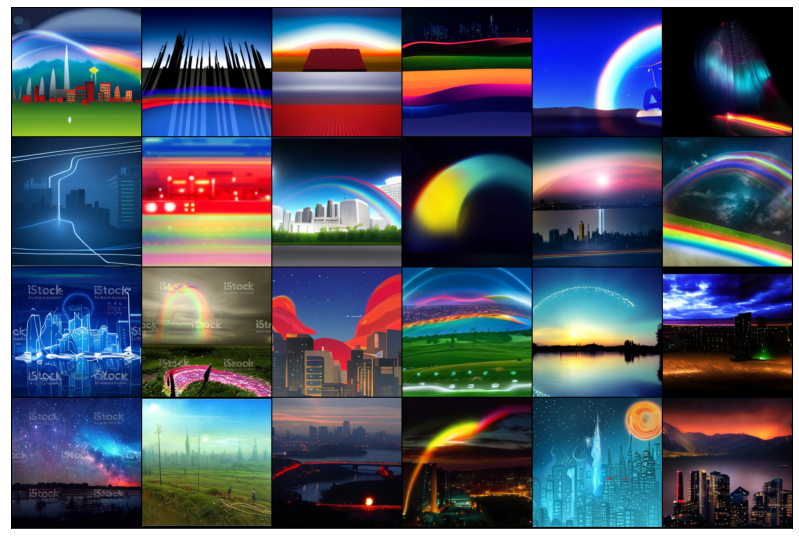

In [6]:
show([pil_image for pil_image, score in sorted(zip(pil_images, scores), key=lambda x: -x[1])] , 6)

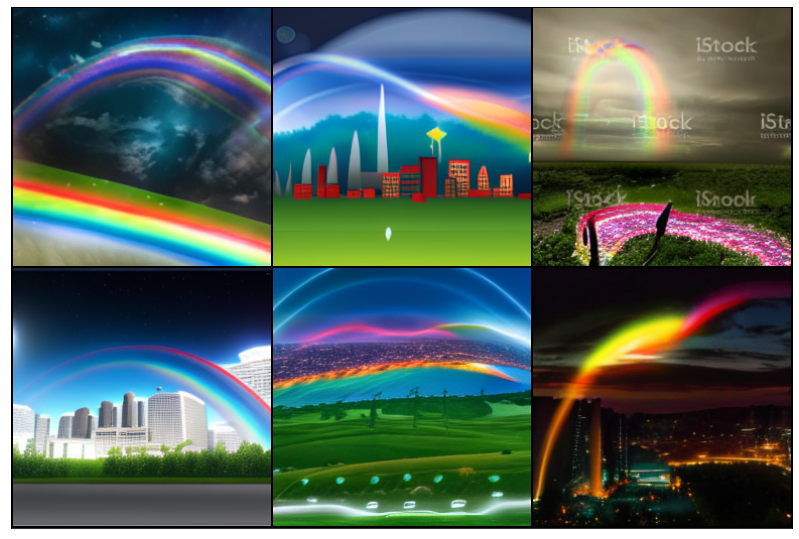

In [7]:
top_images, clip_scores = cherry_pick_by_clip(pil_images, text, ruclip, ruclip_processor, device=device, count=6)
show(top_images, 3)

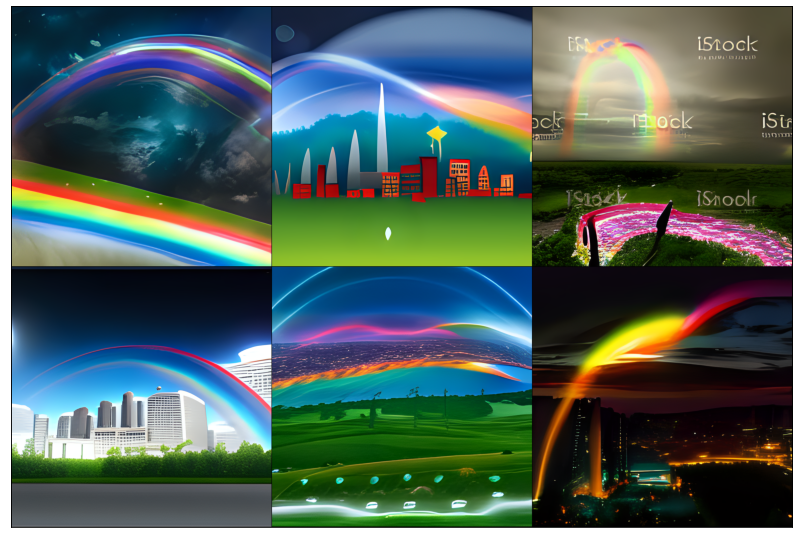

In [8]:
sr_images = super_resolution(top_images, realesrgan)
show(sr_images, 3)